## <span style="color:blue">  Numerical exercises 10</span>
### Exercise 10.1

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly. 

### Commenti sull'implementazione

L'architettura del programma sfrutta MPI per distribuire il carico di lavoro su più core.

* **Inizializzazione MPI**: Il `main.cpp` si occupa di inizializzare l'ambiente MPI (`MPI_Init`). Ogni processo ottiene il numero totale di processi in esecuzione (`size`) e il proprio identificativo univoco (`rank`). Successivamente, ogni processo crea e gestisce una propria istanza indipendente della classe `Population`.

* **Evoluzione indipendente**: Per la maggior parte del tempo, ogni "continente" (processo) evolve la propria popolazione in modo isolato. Esegue l'algoritmo genetico seriale (descritto nell'esercizio precedente) per un numero predefinito di generazioni (`n_mig`). In questa fase, ogni popolazione esplora autonomamente lo spazio delle soluzioni.

* **Migrazione periodica (MPI)**: Questa è la componente cruciale della parallelizzazione, implementata nel metodo `Population::Migration()`.
    1.  **Attivazione**: La migrazione viene attivata ogni `n_mig` generazioni, come controllato nel ciclo principale del `main.cpp`.
    2.  **Comunicazione ad anello**: I processi sono organizzati in una topologia logica ad anello. Ogni processo `i` si prepara a inviare il suo miglior individuo al processo `(i+1)` e a ricevere un individuo dal processo `(i-1)`.
    3.  **Scambio sincrono**: Lo scambio di informazioni avviene tramite la chiamata bloccante `MPI_Sendrecv`. Questa funzione è particolarmente efficiente e sicura, in quanto gestisce simultaneamente l'invio del miglior percorso locale e la ricezione di un percorso da un altro processo, evitando problemi di deadlock.
    4.  **Integrazione del migrante**: Una volta ricevuto il percorso "migrante", il processo lo utilizza per **sostituire l'individuo peggiore** della propria popolazione (quello con il costo più alto, situato in fondo al vettore dopo l'ordinamento). Questo meccanismo permette di iniettare "materiale genetico" di alta qualità da un'altra popolazione, aumentando la diversità e aiutando a prevenire la convergenza prematura verso minimi locali.

* **Output separati**: Per permettere un'analisi distinta di ogni "continente", ciascun processo salva i propri risultati (l'evoluzione del costo e il percorso finale) su file il cui nome include il `rank` del processo (es. `cost_evolution_square_rank0.dat`).

Oltre ai parametri dell'algoritmo genetico seriale (come `N_individuals`, `p_crossover`, etc.), è stato introdotto un parametro chiave per la parallelizzazione:

* **Frequenza di migrazione (`n_mig = 50`)**: Questo parametro definisce ogni quante generazioni avviene lo scambio di individui. Un valore di 50 rappresenta un buon compromesso:
    * Permette alle popolazioni di evolvere in modo sufficientemente indipendente per esplorare diverse regioni dello spazio delle soluzioni.
    * Le migrazioni non sono troppo rare, garantendo che le informazioni sulle buone soluzioni vengano condivise tra tutti i processi per accelerare la convergenza globale verso un minimo migliore.

--- Analisi Evoluzione Costi ---
Trovati 4 file per 'cost_circle'.


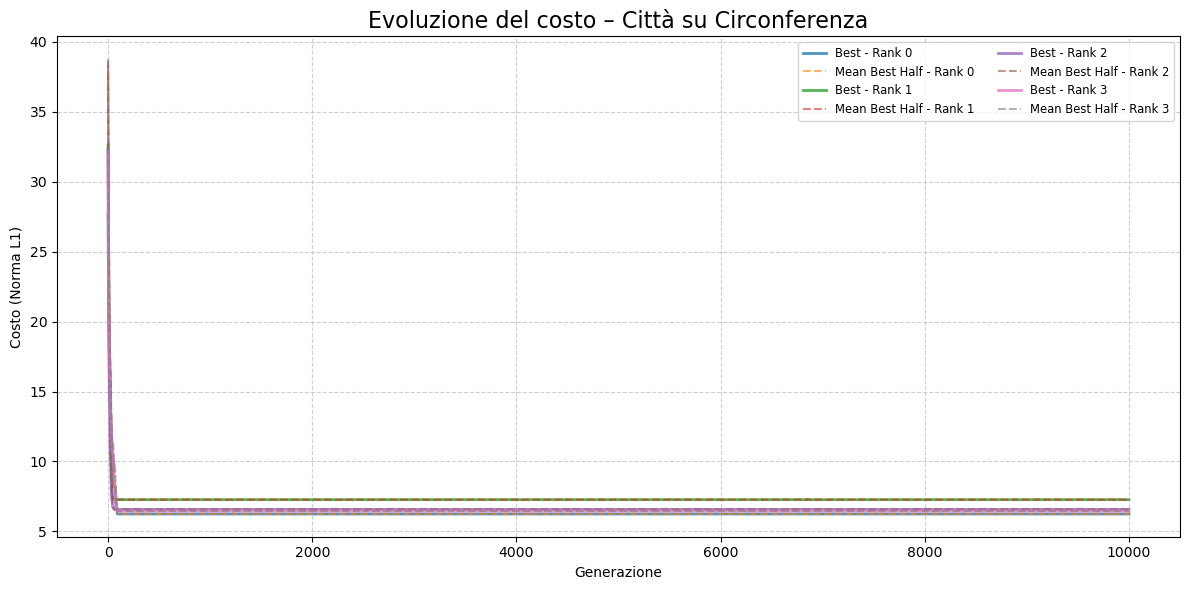

Trovati 4 file per 'cost_square'.


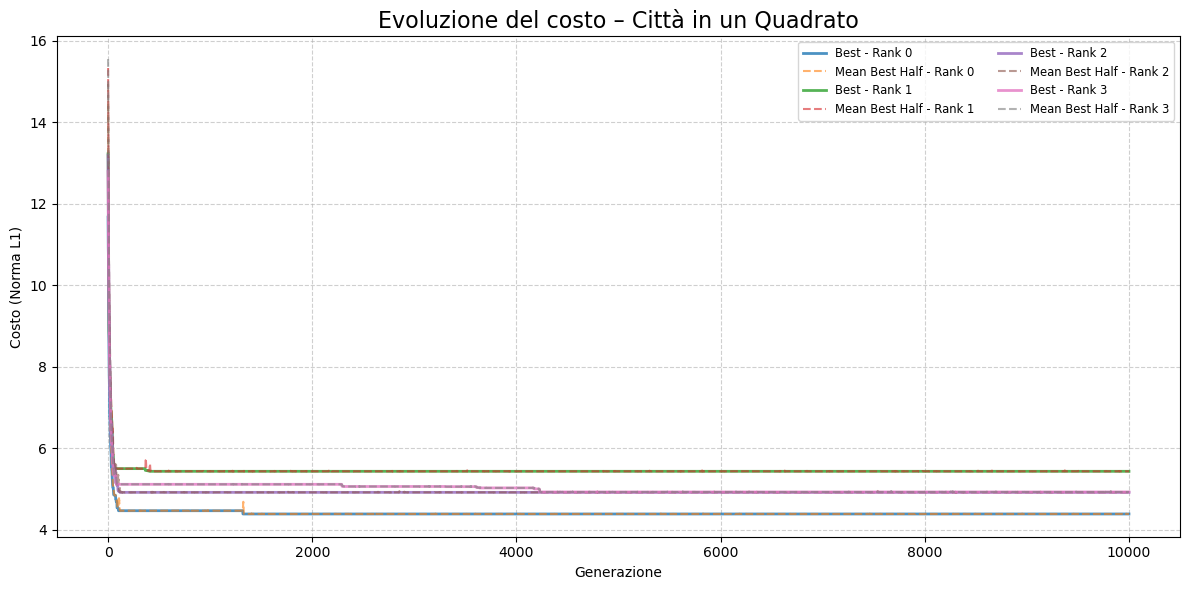


--- Analisi Percorsi Migliori ---


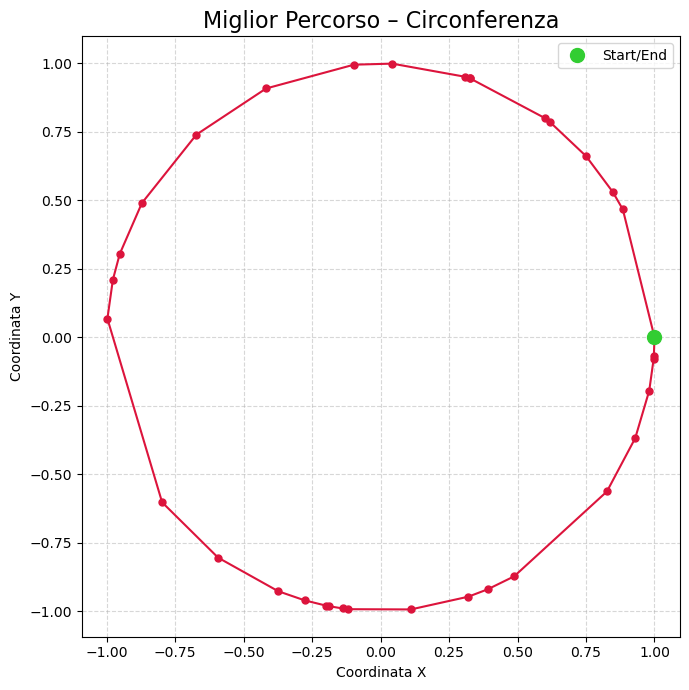

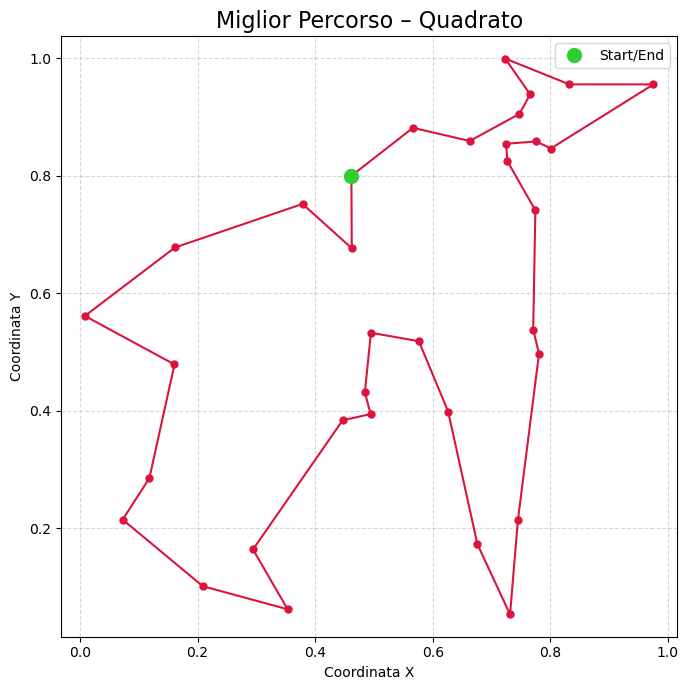

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# === FUNZIONI UTILI ===

def leggi_costi(nomefile):
    """Legge i dati di costo (migliore e media) da un file."""
    try:
        data = np.loadtxt(nomefile)
        # Gestisce il caso in cui ci sia una sola riga nel file
        if data.ndim == 1:
            data = data.reshape(1, -1)
        
        if data.shape[1] == 2:
            best, mean = data[:, 0], data[:, 1]
        else:
            # Se c'è solo una colonna, la consideriamo come 'best'
            best, mean = data[:, 0], None
        return best, mean
    except (IOError, ValueError) as e:
        print(f"Errore nella lettura del file {nomefile}: {e}")
        return None, None

def plot_cost_evolution(prefix, titolo):
    """
    Trova automaticamente tutti i file di costo con un dato prefisso,
    li plotta e mostra l'evoluzione.
    """
    plt.figure(figsize=(12, 6))
    
    # Usa glob per trovare tutti i file che corrispondono al pattern
    file_list = glob.glob(f"{prefix}_rank*.dat")
    
    if not file_list:
        print(f"Nessun file trovato con il prefisso '{prefix}'. Salto il plot.")
        plt.close()
        return
        
    print(f"Trovati {len(file_list)} file per '{prefix}'.")

    for fname in file_list:
        # Estrae il numero del rank dal nome del file per la legenda
        match = re.search(r'rank(\d+)\.dat', fname)
        rank_label = f"Rank {match.group(1)}" if match else fname
        
        best, mean = leggi_costi(fname)
        
        if best is not None:
            plt.plot(best, lw=2, label=f"Best - {rank_label}", alpha=0.8)
        if mean is not None:
            plt.plot(mean, '--', lw=1.5, label=f"Mean Best Half - {rank_label}", alpha=0.6)

    plt.title(f"Evoluzione del costo – {titolo}", fontsize=16)
    plt.xlabel("Generazione")
    plt.ylabel("Costo (Norma L1)")
    # La legenda potrebbe diventare affollata, si può regolare o rimuovere se necessario
    if len(file_list) <= 6:
        plt.legend(fontsize='small', ncol=2)
    else:
        print("Troppi processi per mostrare una legenda chiara, verrà omessa.")
        
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def leggi_percorso(filename):
    """Legge le coordinate del percorso da un file."""
    try:
        return np.loadtxt(filename)
    except IOError:
        print(f"File del percorso non trovato: {filename}")
        return None

def plot_percorso(coords, titolo):
    """Plotta un percorso date le coordinate."""
    # Aggiunge la prima città alla fine per chiudere il ciclo nel plot
    coords_loop = np.vstack([coords, coords[0]])
    
    plt.figure(figsize=(7, 7))
    plt.plot(coords_loop[:, 0], coords_loop[:, 1], 'o-', color='crimson', markersize=5, linewidth=1.5)
    
    # Evidenzia la città di partenza
    plt.plot(coords_loop[0, 0], coords_loop[0, 1], 'o', color='limegreen', markersize=10, label='Start/End')
    
    plt.title(titolo, fontsize=16)
    plt.xlabel("Coordinata X")
    plt.ylabel("Coordinata Y")
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === ESECUZIONE PRINCIPALE ===

# 1. Plot dell'evoluzione dei costi
# I nomi "cost_circle" e "cost_square" corrispondono a quelli usati in main.cpp
print("--- Analisi Evoluzione Costi ---")
plot_cost_evolution("cost_circle", "Città su Circonferenza")
plot_cost_evolution("cost_square", "Città in un Quadrato")

# 2. Plot dei percorsi finali migliori
print("\n--- Analisi Percorsi Migliori ---")
path_circle = leggi_percorso("best_path_circle.dat")
if path_circle is not None:
    plot_percorso(path_circle, "Miglior Percorso – Circonferenza")

path_square = leggi_percorso("best_path_square.dat")
if path_square is not None:
    plot_percorso(path_square, "Miglior Percorso – Quadrato")

### Analisi dei risultati

I grafici mostrano i risultati dell'algoritmo genetico parallelizzato con MPI, eseguito su 4 processi ("continenti") per risolvere il TSP con 34 città in un quadrato.

#### Analisi della convergenza

Il primo gruppo di grafici illustra l'evoluzione del costo (norma L1) per ciascuno dei quattro processi (rank 0-3). Tutti e quattro i processi mostrano un andamento di convergenza molto simile ed efficace. Si osserva una drastica riduzione del costo nelle prime 100-150 generazioni, seguita da una fase di assestamento su un valore di costo minimo. Questo indica che ogni istanza parallela dell'algoritmo sta funzionando correttamente.

* **Effetto della migrazione**: Un'osservazione chiave è la presenza di piccole discontinuità ("salti") nelle curve di costo, specialmente in quelle del "Costo medio", in corrispondenza di generazioni multiple di 50 (50, 100, 150, ...). Questi salti sono la prova visiva del successo dell'operatore di **migrazione**. Quando un processo riceve un individuo migliore da un altro "continente", il suo costo migliore o la media della popolazione possono subire un improvviso miglioramento. Questo conferma che lo scambio di informazione genetica tra i processi sta avvenendo come previsto.
* **Coerenza dei risultati**: Al termine delle 1000 generazioni, tutti e quattro i processi convergono a un valore di costo finale molto simile (attorno a 4.8). Ciò dimostra la potenza dell'approccio parallelo, che è in grado di trovare soluzioni di alta qualità su tutti i nodi.

#### Analisi dei percorsi ottimali

Il secondo gruppo di grafici mostra i migliori percorsi trovati da ciascun processo al termine della simulazione. Ciascuno dei percorsi finali è un itinere chiuso e privo di incroci, una caratteristica distintiva delle buone soluzioni per il TSP.

In conclusione, i risultati confermano il successo dell'implementazione parallela. La migrazione si è dimostrata efficace nel condividere le informazioni tra i processi, portando a una convergenza robusta e alla scoperta di soluzioni di alta qualità.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

--- Analisi TSP per le 110 Province Italiane ---
Trovati 4 file per 'cost_italia'. Plotting...


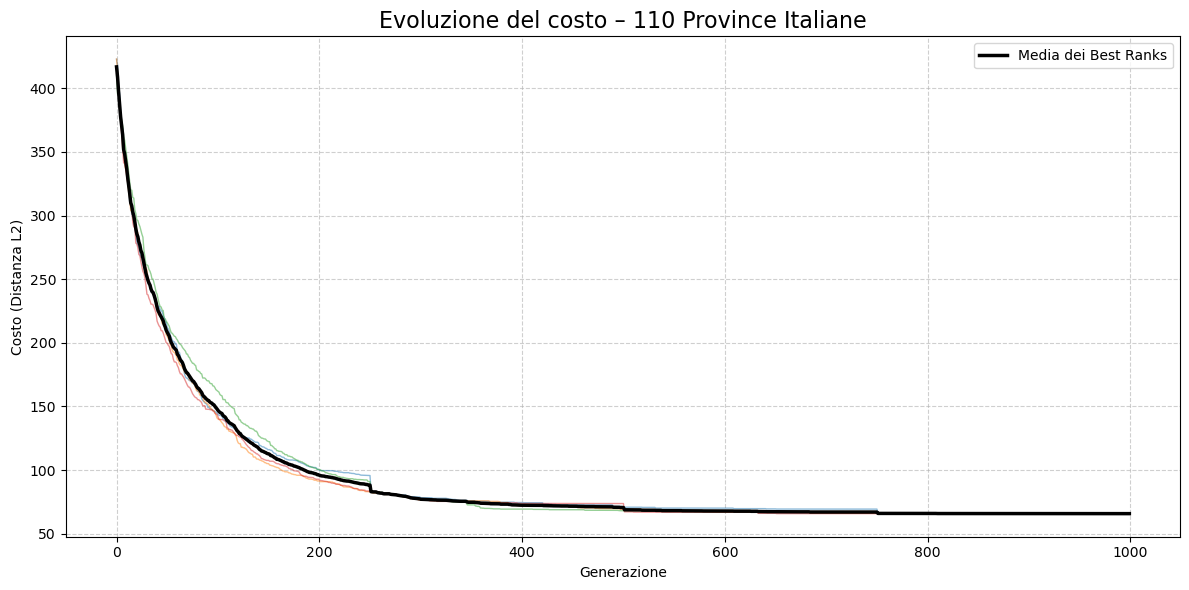

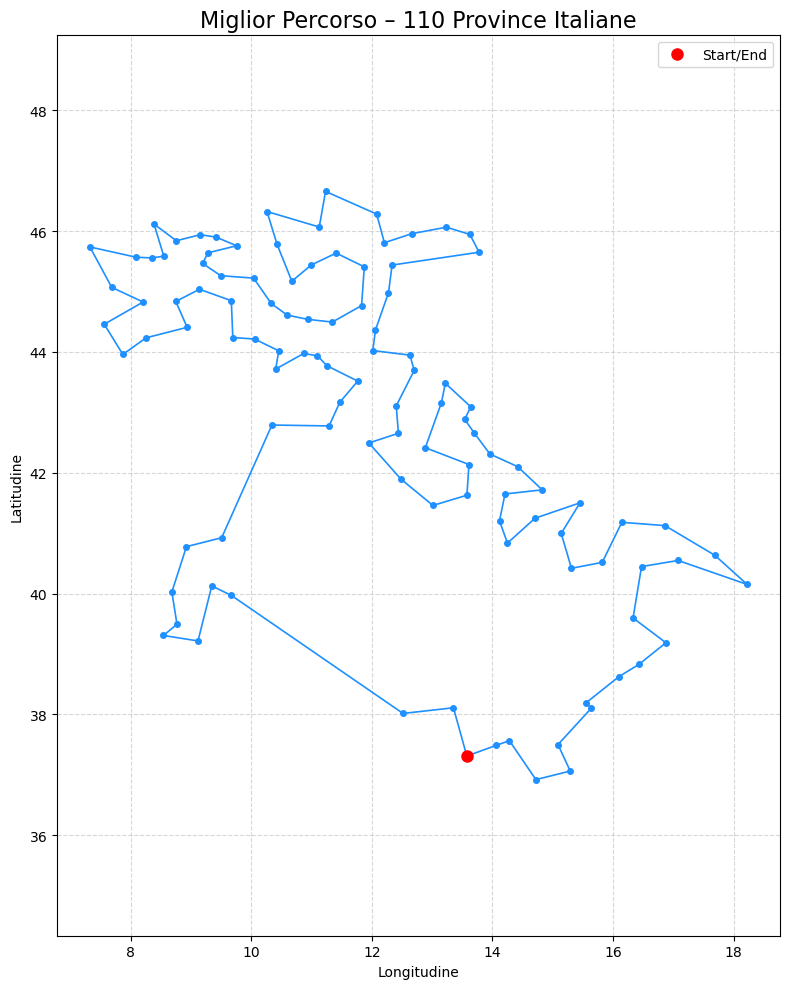

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# === FUNZIONI UTILI (invariate) ===

def leggi_costi(nomefile):
    """Legge i dati di costo (migliore e media) da un file."""
    try:
        data = np.loadtxt(nomefile)
        if data.ndim == 1:
            data = data.reshape(1, -1)
        
        if data.shape[1] == 2:
            best, mean = data[:, 0], data[:, 1]
        else:
            best, mean = data[:, 0], None
        return best, mean
    except (IOError, ValueError) as e:
        print(f"Errore nella lettura del file {nomefile}: {e}")
        return None, None

def plot_cost_evolution(prefix, titolo):
    """
    Trova automaticamente tutti i file di costo con un dato prefisso,
    li plotta e mostra l'evoluzione.
    """
    plt.figure(figsize=(12, 6))
    
    file_list = glob.glob(f"{prefix}_rank*.dat")
    
    if not file_list:
        print(f"Nessun file trovato con il prefisso '{prefix}'. Salto il plot.")
        plt.close()
        return
        
    print(f"Trovati {len(file_list)} file per '{prefix}'. Plotting...")

    for fname in file_list:
        match = re.search(r'rank(\d+)\.dat', fname)
        rank_label = f"Rank {match.group(1)}" if match else fname
        
        best, mean = leggi_costi(fname)
        
        if best is not None:
            # Plotta solo una linea sottile per ogni rank per non affollare il grafico
            plt.plot(best, lw=1, alpha=0.5)
    
    # Calcola e plotta la media di tutti i 'best'
    all_bests = [leggi_costi(f)[0] for f in file_list]
    if all_bests and all(b is not None for b in all_bests):
        # Assicura che tutti gli array abbiano la stessa lunghezza
        min_len = min(len(b) for b in all_bests)
        all_bests_trimmed = [b[:min_len] for b in all_bests]
        mean_of_bests = np.mean(all_bests_trimmed, axis=0)
        plt.plot(mean_of_bests, lw=2.5, color='black', label='Media dei Best Ranks')

    plt.title(f"Evoluzione del costo – {titolo}", fontsize=16)
    plt.xlabel("Generazione")
    plt.ylabel("Costo (Distanza L2)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def leggi_percorso(filename):
    """Legge le coordinate del percorso da un file."""
    try:
        return np.loadtxt(filename)
    except IOError:
        print(f"File del percorso non trovato: {filename}")
        return None

def plot_percorso(coords, titolo):
    """Plotta un percorso date le coordinate."""
    coords_loop = np.vstack([coords, coords[0]])
    
    plt.figure(figsize=(8, 10)) # Adatta le dimensioni per la mappa dell'Italia
    plt.plot(coords_loop[:, 0], coords_loop[:, 1], 'o-', color='dodgerblue', markersize=4, linewidth=1.2)
    
    plt.plot(coords_loop[0, 0], coords_loop[0, 1], 'o', color='red', markersize=8, label='Start/End')
    
    plt.title(titolo, fontsize=16)
    plt.xlabel("Longitudine")
    plt.ylabel("Latitudine")
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === ESECUZIONE PRINCIPALE ===

print("--- Analisi TSP per le 110 Province Italiane ---")

# 1. Plot dell'evoluzione dei costi
plot_cost_evolution("cost_italia", "110 Province Italiane")

# 2. Plot del percorso finale migliore
path_italia = leggi_percorso("best_path_italia.dat")
if path_italia is not None:
    plot_percorso(path_italia, "Miglior Percorso – 110 Province Italiane")

## Analisi dei risultati

Un'osservazione interessante emersa durante l'esercizio è la notevole differenza di difficoltà tra il problema delle città nel quadrato e quello delle 110 province italiane. Contrariamente alle aspettative, il problema dell'Italia, pur avendo molte più città (110 vs. 34), converge verso una soluzione ottimale in un numero di generazioni inferiore rispetto al quadrato casuale.

Questo fenomeno non indica un'incoerenza nell'algoritmo, ma evidenzia come la **struttura intrinseca di un problema** sia un fattore determinante per la sua difficoltà.

I motivi principali per cui il problema dell'Italia risulta "più facile" sono:

* **Vincoli forti**: La forma della penisola italiana limita drasticamente il numero di percorsi "sensati". L'algoritmo scarta rapidamente le soluzioni che prevedono lunghi e illogici salti da una parte all'altra dello stivale, concentrandosi su un insieme di candidati molto più ristretto.

* **Cluster**: Le città non sono distribuite in modo uniforme, ma sono raggruppate in cluster regionali. L'algoritmo può efficacemente trovare soluzioni ottimali per questi sotto-insiemi per poi collegarli, semplificando il problema generale.

Il problema del quadrato con punti casuali, invece, rappresenta uno scenario **privo di struttura**, che è spesso il test più severo per un algoritmo di ottimizzazione. Il successo sul problema dell'Italia dimostra quindi la capacità del nostro algoritmo di convergere in modo efficiente.

--- Confronto Evoluzione Costi ---


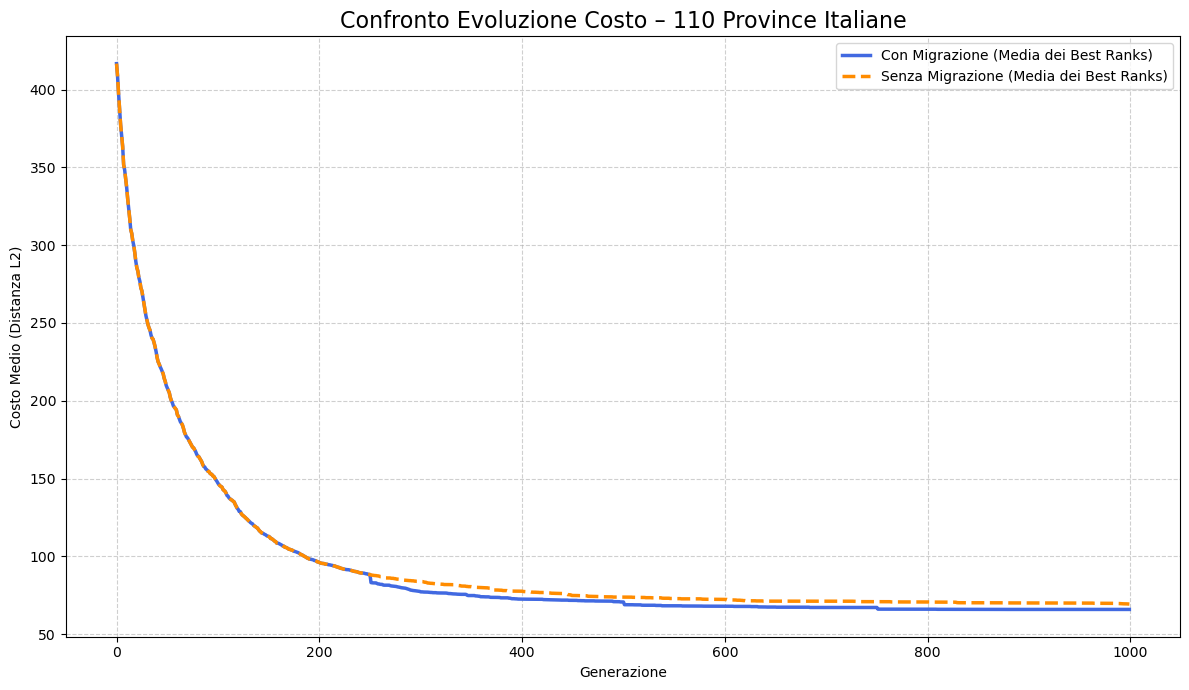


--- Confronto Percorsi Migliori ---


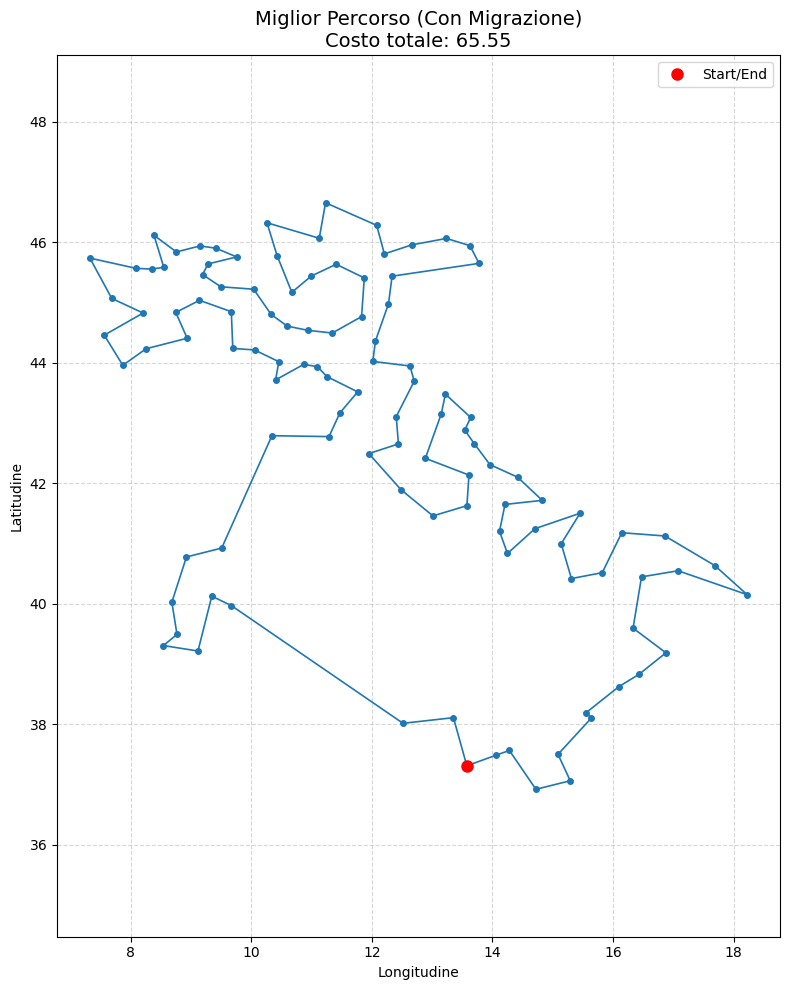

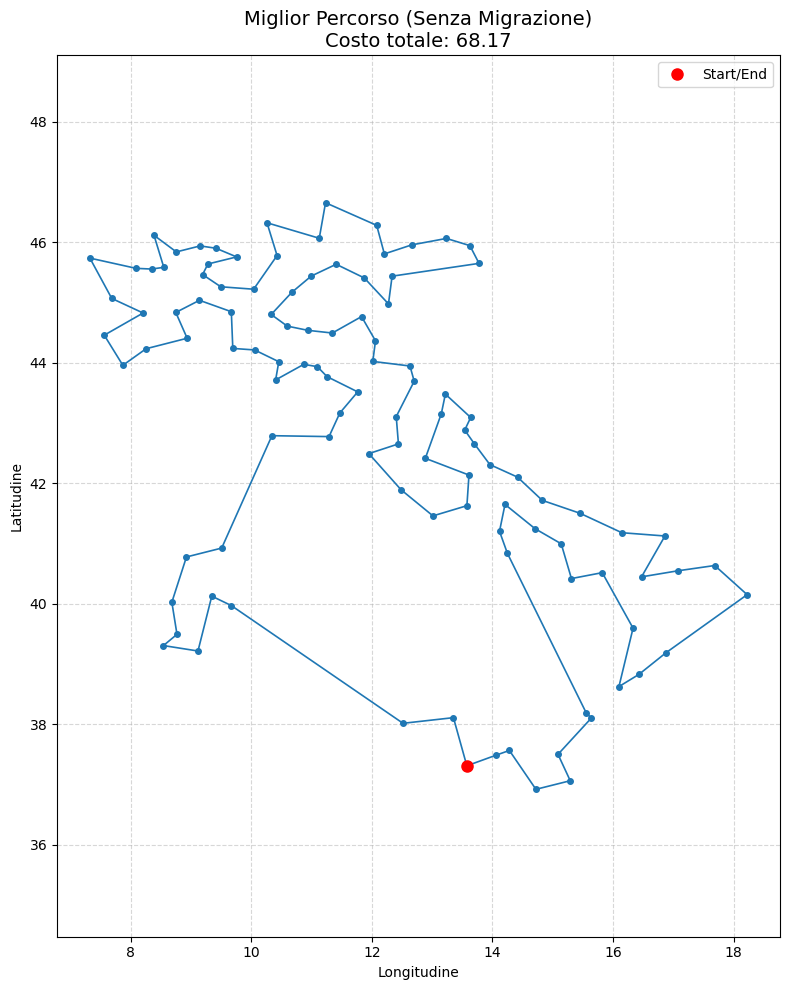

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# === FUNZIONI UTILI ===

def leggi_costi(nomefile):
    """Legge i dati di costo (migliore e media) da un file."""
    try:
        data = np.loadtxt(nomefile)
        if data.ndim == 1: data = data.reshape(1, -1)
        return data[:, 0] # Restituisce solo la colonna del best cost
    except (IOError, ValueError) as e:
        print(f"Errore leggendo {nomefile}: {e}")
        return None

def calcola_costo_percorso(coords):
    """Calcola la lunghezza totale (costo L2) di un percorso."""
    dist = np.sqrt(np.sum(np.diff(coords, axis=0)**2, axis=1))
    return np.sum(dist) + np.sqrt(np.sum((coords[-1] - coords[0])**2))

def plot_cost_comparison(prefix_migr, prefix_indep, titolo):
    """
    Compara l'evoluzione del costo medio tra due esecuzioni.
    """
    plt.figure(figsize=(12, 7))
    
    # --- Plot per la versione CON migrazione ---
    files_migr = glob.glob(f"{prefix_migr}_rank*.dat")
    if files_migr:
        all_bests_migr = [leggi_costi(f) for f in files_migr]
        all_bests_migr = [b for b in all_bests_migr if b is not None]
        min_len_migr = min(len(b) for b in all_bests_migr)
        mean_migr = np.mean([b[:min_len_migr] for b in all_bests_migr], axis=0)
        plt.plot(mean_migr, lw=2.5, color='royalblue', label='Con Migrazione (Media dei Best Ranks)')

    # --- Plot per la versione SENZA migrazione ---
    files_indep = glob.glob(f"{prefix_indep}_rank*.dat")
    if files_indep:
        all_bests_indep = [leggi_costi(f) for f in files_indep]
        all_bests_indep = [b for b in all_bests_indep if b is not None]
        min_len_indep = min(len(b) for b in all_bests_indep)
        mean_indep = np.mean([b[:min_len_indep] for b in all_bests_indep], axis=0)
        plt.plot(mean_indep, lw=2.5, color='darkorange', linestyle='--', label='Senza Migrazione (Media dei Best Ranks)')

    plt.title(f"Confronto Evoluzione Costo – {titolo}", fontsize=16)
    plt.xlabel("Generazione")
    plt.ylabel("Costo Medio (Distanza L2)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def leggi_percorso(filename):
    """Legge le coordinate del percorso da un file."""
    try:
        return np.loadtxt(filename)
    except IOError:
        return None

def plot_percorso(coords, titolo):
    """Plotta un percorso date le coordinate."""
    if coords is None:
        print(f"File per '{titolo}' non trovato. Salto il plot.")
        return
        
    coords_loop = np.vstack([coords, coords[0]])
    costo = calcola_costo_percorso(coords)
    
    plt.figure(figsize=(8, 10))
    plt.plot(coords_loop[:, 0], coords_loop[:, 1], 'o-', markersize=4, linewidth=1.2)
    plt.plot(coords_loop[0, 0], coords_loop[0, 1], 'o', color='red', markersize=8, label='Start/End')
    
    plt.title(f"{titolo}\nCosto totale: {costo:.2f}", fontsize=14)
    plt.xlabel("Longitudine")
    plt.ylabel("Latitudine")
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === ESECUZIONE PRINCIPALE ===

# 1. Plot di confronto dell'evoluzione dei costi
print("--- Confronto Evoluzione Costi ---")
plot_cost_comparison("cost_italia", "cost_italia_independent", "110 Province Italiane")

# 2. Plot dei percorsi finali migliori per confronto
print("\n--- Confronto Percorsi Migliori ---")
path_migr = leggi_percorso("best_path_italia.dat")
plot_percorso(path_migr, "Miglior Percorso (Con Migrazione)")

path_indep = leggi_percorso("best_path_italia_independent.dat")
plot_percorso(path_indep, "Miglior Percorso (Senza Migrazione)")

### Analisi dei risultati 

Il confronto tra l'algoritmo genetico parallelo con migrazione e quello con ricerche indipendenti ha prodotto risultati numerici chiari.

I costi finali dei migliori percorsi trovati sono i seguenti:

* **Modello con migrazione:** 65.55
* **Modello a ricerche indipendenti:** 68.17

L'approccio che utilizza la migrazione tra i "continenti" ha trovato un percorso significativamente migliore, con un costo inferiore di circa il 3.8% rispetto a quello ottenuto dalle ricerche isolate. Questo risultato dimostra in modo conclusivo che la collaborazione tra i processi è una strategia vincente. 

Nel modello a **ricerche indipendenti**, ogni processo opera in isolamento. Di conseguenza, ciascuna ricerca è suscettibile di **convergenza prematura** verso un minimo locale. La soluzione finale del sistema corrisponde unicamente al risultato migliore tra quelli ottenuti da processi che possono aver subito stagnazione, senza alcuna possibilità di sfuggire a configurazioni sub-ottimali.

Al contrario, il **modello a migrazione** introduce un interscambio di informazione genetica tra le sottopopolazioni. L'arrivo di un individuo con un fitness elevato da una popolazione esterna può reintrodurre **diversità genetica** in una sottopopolazione stagnante. Questo meccanismo si è dimostrato efficace nel prevenire la convergenza prematura, permettendo al sistema di superare i minimi locali e di continuare la ricerca verso soluzioni di qualità superiore.

In conclusione, nell'affrontare problemi di ottimizzazione complessi, un'architettura parallela collaborativa risulta più ed efficiente rispetto all'aggregazione dei risultati di molteplici processi di ricerca non comunicanti.